# Visualizing Errors

For any scientific measurement, accurate accounting for errors is nearly as important, if not more important, than accurate reporting of the number itself.
For example, imagine that I am using some astrophysical observations to estimate the Hubble Constant, the local measurement of the expansion rate of the Universe.
I know that the current literature suggests a value of around 71 (km/s)/Mpc, and I measure a value of 74 (km/s)/Mpc with my method. Are the values consistent? The only correct answer, given this information, is this: there is no way to know.

Suppose I augment this information with reported uncertainties: the current literature suggests a value of around 71 $\pm$ 2.5 (km/s)/Mpc, and my method has measured a value of 74 $\pm$ 5 (km/s)/Mpc. Now are the values consistent? That is a question that can be quantitatively answered.

In visualization of data and results, showing these errors effectively can make a plot convey much more complete information.

## Basic Errorbars

A basic errorbar can be created with a single Matplotlib function call:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

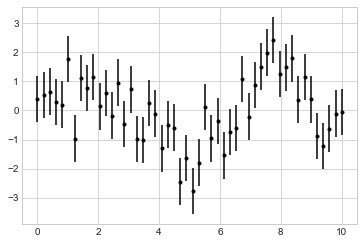

In [2]:
x = np.linspace(0, 10, 50)
dy = 0.8
y = np.sin(x) + dy * np.random.randn(50)

plt.errorbar(x, y, yerr=dy, fmt='.k');

Here the ``fmt`` is a format code controlling the appearance of lines and points, and has the same syntax as the shorthand used in ``plt.plot``, outlined in *Simple Line Plots* and *Simple Scatter Plots*.

In addition to these basic options, the ``errorbar`` function has many options to fine-tune the outputs.
Using these additional options you can easily customize the aesthetics of your errorbar plot.
I often find it helpful, especially in crowded plots, to make the errorbars lighter than the points themselves:

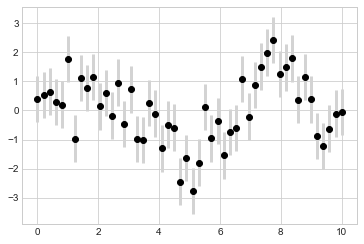

In [3]:
plt.errorbar(x, y, yerr=dy, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

In addition to these options, you can also specify horizontal errorbars (``xerr``), one-sided errorbars, and many other variants.
For more information on the options available, refer to the docstring of ``plt.errorbar``.

## Continuous Errors

In some situations it is desirable to show errorbars on continuous quantities.
Though Matplotlib does not have a built-in convenience routine for this type of application, it's relatively easy to combine primitives like ``plt.plot`` and ``plt.fill`` for a useful result.

Here we'll perform a simple *Gaussian process regression*, using the Scikit-Learn API (see *Introducing Scikit-Learn* for details).
This is a method of fitting a very flexible non-parametric function to data with a continuous measure of the uncertainty.
We won't delve into the details of Gaussian process regression at this point, but will focus instead on how you might visualize such a continuous error measurement:

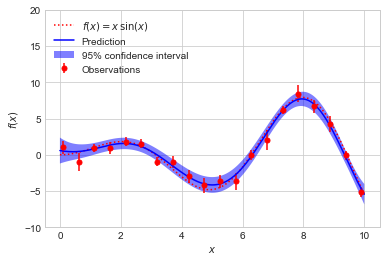

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# data
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

We now have ``xfit``, ``yfit``, and ``dyfit``, which sample the continuous fit to our data.
We could pass these to the ``plt.errorbar`` function as above, but we don't really want to plot 1,000 points with 1,000 errorbars.
Instead, we can use the ``plt.fill`` function with a light color to visualize this continuous error:

Note what we've done here with the ``fill`` function: we pass an x value, then the lower y-bound, then the upper y-bound, and the result is that the area between these regions is filled.

The resulting figure gives a very intuitive view into what the Gaussian process regression algorithm is doing: in regions near a measured data point, the model is strongly constrained and this is reflected in the small model errors.
In regions far from a measured data point, the model is not strongly constrained, and the model errors increase.

For more information on the options available in ``plt.fill()``, see the function docstring or the Matplotlib documentation.

Finally, if this seems a bit too low level for your taste, refer to *Visualization With Seaborn*, where we discuss the Seaborn package, which has a more streamlined API for visualizing this type of continuous errorbar.